# Determining the cost of cars

A car sales service is currently in the process of developing an application with the goal of attracting customers. This application will allow users to easily determine the market value of their cars. The application will provide access to historical data, including technical specifications and prices, which will be used to build a predictive model capable of accurately estimating the cost of a car.

Key considerations for the development of this application include ensuring the quality of the predictions, optimizing prediction speed, and minimizing the amount of time needed for model training and study. These factors will be crucial in creating an efficient and user-friendly application that provides accurate and timely information to potential customers.


## Data preparation

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

In [2]:
data = pd.read_csv("autos.csv")

In [3]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.columns = [x.lower() for x in data.columns]

Irrelevant features in the dataset include datecrawled, registrationmonth, datecreated, numberofpictures, postalcode, lastseen. These features do not have any impact on pricing and solely serve as indicators associated with the users who post the data. Therefore, it is safe to remove these columns and proceed with further exploration of the dataset.

In [5]:
data = data.drop(
    columns=[
        "datecrawled",
        "registrationmonth",
        "datecreated",
        "numberofpictures",
        "postalcode",
        "lastseen",
    ],
    axis=1,
)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354369 non-null  int64 
 1   vehicletype       316879 non-null  object
 2   registrationyear  354369 non-null  int64 
 3   gearbox           334536 non-null  object
 4   power             354369 non-null  int64 
 5   model             334664 non-null  object
 6   kilometer         354369 non-null  int64 
 7   fueltype          321474 non-null  object
 8   brand             354369 non-null  object
 9   repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [7]:
data.duplicated().sum()

45040

Getting rid of duplicates.

In [8]:
data = data.drop_duplicates().sort_index(ascending=True)

We examine the dataset for NaN.

In [9]:
data.isna().mean() * 100

price                0.000000
vehicletype         11.172247
registrationyear     0.000000
gearbox              5.562686
power                0.000000
model                5.935751
kilometer            0.000000
fueltype             9.945398
brand                0.000000
repaired            20.870335
dtype: float64

The percentage of gaps is high, they must be filled.

In [10]:
data = data.fillna("unknown").copy()

<Axes: >

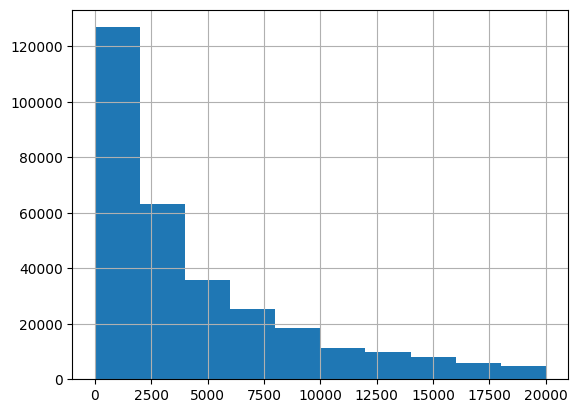

In [11]:
data["price"].hist()

In [12]:
data.loc[data["price"] <= 100].count()

price               12220
vehicletype         12220
registrationyear    12220
gearbox             12220
power               12220
model               12220
kilometer           12220
fueltype            12220
brand               12220
repaired            12220
dtype: int64

In [13]:
data.loc[data["price"] <= 10].count()

price               10122
vehicletype         10122
registrationyear    10122
gearbox             10122
power               10122
model               10122
kilometer           10122
fueltype            10122
brand               10122
repaired            10122
dtype: int64

In [14]:
data = data.loc[data["price"] >= 10]

In [15]:
data.head(5)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [16]:
data = data.loc[(data["power"] >= 50) & (data["power"] <= 400)]

In [17]:
data = data.loc[(data["registrationyear"] >= 1965) & (data["registrationyear"] <= 2016)]

Let's convert the data to numeric form.

Separate dataset for linear regression.

In [18]:
data_ohe = pd.get_dummies(data, drop_first=True)

Another dataset for tree systems.

In [19]:
encoder = OrdinalEncoder()

In [20]:
ordinal_columns = [
    "vehicletype",
    "gearbox",
    "model",
    "fueltype",
    "brand",
    "repaired",
]

data_ord = data.copy()

data_ord[ordinal_columns] = encoder.fit_transform(data_ord[ordinal_columns])

Pre-processing completed, duplicates and omissions removed. We are present for training models.

## Model training

Let's divide the dataset into features and targets.

**For linear regression**

In [21]:
target_ohe = data_ohe["price"]
features_ohe = data_ohe.drop("price", axis=1)

In [22]:
(
    features_train_ohe,
    features_test,
    target_train_ohe,
    target_test,
) = train_test_split(features_ohe, target_ohe, test_size=0.4, random_state=12345)

(
    features_test_ohe,
    features_valid_ohe,
    target_test_ohe,
    target_valid_ohe,
) = train_test_split(features_test, target_test, test_size=0.5, random_state=12345)

We scale indicators.

In [23]:
numeric = ["registrationyear", "power", "kilometer"]

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

**For tree solutions**

In [24]:
target_ord = data_ord["price"]
features_ord = data_ord.drop("price", axis=1)

In [25]:
(
    features_train_ord,
    features_test,
    target_train_ord,
    target_test,
) = train_test_split(features_ord, target_ord, test_size=0.4, random_state=12345)

(
    features_test_ord,
    features_valid_ord,
    target_test_ord,
    target_valid_ord,
) = train_test_split(features_test, target_test, test_size=0.5, random_state=12345)

Create models and select using the **GridSearch** method

In [26]:
def rmse(X, y):
    return math.sqrt(mse(X, y))

In [27]:
rmse = make_scorer(rmse, greater_is_better=False)

**Decision Tree**


In [28]:
STATE = 12345

In [29]:
params_dtr = {"max_depth": range(1, 6)}

model_dtr = DecisionTreeRegressor(random_state=STATE)

grid_dtr = GridSearchCV(
    model_dtr, param_grid=params_dtr, cv=5, scoring=rmse, refit=True
)
grid_dtr.fit(features_train_ord, target_train_ord)
params_dtr = grid_dtr.best_params_
grid_dtr_best = DecisionTreeRegressor(**params_dtr, random_state=STATE)
grid_dtr_best

DecisionTreeRegressor(max_depth=5, random_state=12345)

**Random Forest**

In [30]:
params_rfr = {"max_depth": range(1, 20, 5)}

model_rfr = RandomForestRegressor(random_state=STATE)

grid_rfr = GridSearchCV(model_rfr, params_rfr, cv=3, n_jobs=-1, verbose=2, scoring=rmse)
grid_rfr.fit(features_train_ord, target_train_ord)
params_rfr = grid_rfr.best_params_
grid_rfr_best = RandomForestRegressor(**params_rfr, random_state=STATE)
grid_rfr_best

Fitting 3 folds for each of 4 candidates, totalling 12 fits


RandomForestRegressor(max_depth=16, random_state=12345)

**Linear Regression**

In [31]:
model_lr = LinearRegression()
parameters = {"fit_intercept": [True, False], "copy_X": [True, False]}
grid_lr = GridSearchCV(model_lr, param_grid=parameters, cv=5, scoring=rmse, refit=True)
grid_lr.fit(features_train_ohe, target_train_ohe)
params_lr = grid_lr.best_params_
grid_lr_best = LinearRegression(**params_lr)
grid_lr_best

LinearRegression(fit_intercept=False)

**Gradient boosting**

In [32]:
parameters = {
    "max_depth": [15, 25, 35],
    "learning_rate": [0.01, 0.05, 0.15],
}
model_lgb = lgb.LGBMRegressor()
grid_lgb = GridSearchCV(model_lgb, param_grid=parameters, scoring=rmse, cv=3)
grid_lgb.fit(features_train_ohe, target_train_ohe)
params_lgb = grid_lgb.best_params_
grid_lgb_best = lgb.LGBMRegressor(**params_lgb)
grid_lgb_best

LGBMRegressor(learning_rate=0.15, max_depth=15)

## Analysis of models

Let's take measurements of training and prediction time.

**Decision Tree**

In [33]:
%time grid_dtr_best.fit(features_train_ord, target_train_ord)
%time predicted_valid_dtr = grid_dtr_best.predict(features_valid_ord)

CPU times: user 98 ms, sys: 4.47 ms, total: 102 ms
Wall time: 95 ms
CPU times: user 2.98 ms, sys: 0 ns, total: 2.98 ms
Wall time: 2.77 ms


In [34]:
print("RMSE DTR:", math.sqrt(mse(target_valid_ord, predicted_valid_dtr)))

RMSE DTR: 2437.0630508688632


**Random Forest**

In [35]:
%time grid_rfr_best.fit(features_train_ord, target_train_ord)
%time predicted_valid_rfr = grid_rfr_best.predict(features_valid_ord)

CPU times: user 17.1 s, sys: 71.3 ms, total: 17.1 s
Wall time: 17.1 s
CPU times: user 548 ms, sys: 466 µs, total: 549 ms
Wall time: 548 ms


In [36]:
print("RMSE RFR:", math.sqrt(mse(target_valid_ord, predicted_valid_rfr)))

RMSE RFR: 1670.9583167824987


**Linear Regression**

In [37]:
%time grid_lr_best.fit(features_train_ohe, target_train_ohe)
%time predicted_valid_lr = grid_lr_best.predict(features_valid_ohe)

CPU times: user 16.6 s, sys: 5.51 s, total: 22.1 s
Wall time: 3.9 s
CPU times: user 93.9 ms, sys: 282 ms, total: 375 ms
Wall time: 48.3 ms


In [38]:
print("RMSE LR:", math.sqrt(mse(target_valid_ohe, predicted_valid_lr)))

RMSE LR: 2547.5481551905546


**LightGBM**

In [39]:
%time grid_lgb_best.fit(features_train_ohe, target_train_ohe)
%time predicted_valid_lgb = grid_lgb_best.predict(features_valid_ohe)

CPU times: user 2.63 s, sys: 409 ms, total: 3.04 s
Wall time: 633 ms
CPU times: user 414 ms, sys: 19.9 ms, total: 434 ms
Wall time: 101 ms


In [40]:
print("RMSE LGB:", math.sqrt(mse(target_valid_ohe, predicted_valid_lgb)))

RMSE LGB: 1653.9804003077002


In [41]:
table = [
    [
        math.sqrt(mse(target_valid_ord, predicted_valid_dtr)),
        math.sqrt(mse(target_valid_ord, predicted_valid_rfr)),
        math.sqrt(mse(target_valid_ohe, predicted_valid_lr)),
        math.sqrt(mse(target_valid_ohe, predicted_valid_lgb)),
    ],
    ["211 ms", "28.9 s", "35.5 ms", "38,9 s"],
    ["4.99 ms", "1,06 s", "3,29 ms", "597 ms"],
]
columns = ["dtr", "rfr", "lr", "lgb"]
index = ["RMSE", "fit_time", "predict_time"]
table_1 = pd.DataFrame(table, index, columns)
display(table_1)

,dtr,rfr,lr,lgb
RMSE,2437.063051,1670.958317,2547.548155,1653.9804
fit_time,211 ms,28.9 s,35.5 ms,"38,9 s"
predict_time,4.99 ms,"1,06 s","3,29 ms",597 ms


As can be seen from the table, the method showing the most appropriate RMSE values and fit_time calues is **LR**. The second after it is **DTR**.

## Model testing

**Linear Regression**

In [42]:
predicted_test_lr = grid_lr_best.predict(features_test_ohe)
print("RMSE LR:", math.sqrt(mse(target_test_ohe, predicted_test_lr)))

RMSE LR: 5324935236668.029


**Decision Tree Classifier**

In [43]:
predicted_test_dtr = grid_dtr_best.predict(features_test_ord)
print("RMSE DTR:", math.sqrt(mse(target_test_ord, predicted_test_dtr)))

RMSE DTR: 2434.6830159169


In [44]:
table_1 = [
    [
        math.sqrt(mse(target_test_ohe, predicted_test_lr)),
        math.sqrt(mse(target_test_ord, predicted_test_dtr)),
    ]
]
columns = ["LR", "DTR"]
index = ["RMSE"]
table_2 = pd.DataFrame(table_1, index, columns)
display(table_2)

,LR,DTR
RMSE,5.324935e+12,2434.683016


The intermediate conclusions were validated on the test sample, affirming the findings.

In terms of results, LR (Linear Regression) is considerably more advantageous.

This conclusion is based on the criteria specified by the customer, which include:

    Prediction accuracy
    Model training time
    Model prediction time